This code represents an attempt to replicate the DeepClean 1D convolutional neural network to reduce the signal-to-noise ratio in gravitational waves.

In [2]:
#Given pseudocode to grab the .h5 data file
import numpy as np
import h5py
from scipy import signal
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("data/deepclean-1251335314-4097.h5", "r") as f:
    X = []
    for channel, timeseries in f.items():
        if channel == "H1:GDS-CALIB_STRAIN":
            y = timeseries[:]
        else:
            X.append(timeseries[:])
X = np.stack(X, axis=-1) # this will do channels last (as is typically done for Keras)
print(X.shape)
print(y.shape)



(16781312, 21)
(16781312,)


(32, 32768, 21)
(32, 32768)


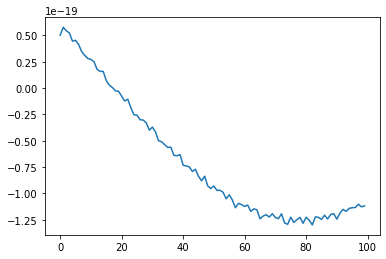

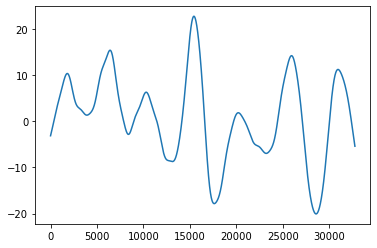

In [19]:

# then to construct inputs/outputs, you just
# slice windows from these two timeseries
window_length = 8
sample_rate = 4096
window_size = window_length * sample_rate

# sample a batch of random windows
batch_size = 32
X_batch, y_batch = [], []
for i in range(batch_size):
    idx = np.random.randint(X.shape[0] - window_size)
    X_batch.append(X[idx: idx + window_size])
    y_batch.append(y[idx: idx + window_size])

X_batch = np.stack(X_batch)
y_batch = np.stack(y_batch)

print(X_batch.shape)
print(y_batch.shape)

plt.plot(y[0:100])
plt.show()
plt.plot(X_batch[0][:, 0])
plt.show()



strain_data = y_batch
witness_data = X_batch
channels = 21

Building Butterworth Filter


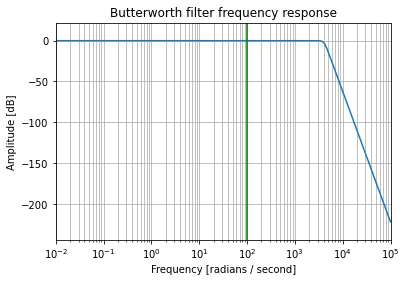

Butterworth filter built


In [88]:
#Preprocessing:
#Normalize the data
"""
Pre-processing data structure:

1. Anti-Imaging filter: Resample witness channels, Y, to the same frequency as the strain;
    - Currently, witness and strain are all sampled at 4096 Hz
2. 8th Order Butterworth: Aliasing filter to mitigate power from outside the witnessed noise frequencies;

3. StandardScalar: Unit variance, Zero mean;

4. Windowing: Divide data into smaller overlapping windows;
    - Segment Length: 8.00 Seconds;
    - 0.5 Hz => DFT of 2 Seconds;
    
5. Welches Method: 1 Second DFT overlap;

6. Training: Segment overlap [%] = 96.875

7. Testing: Segment overlap [%] = 50%
"""

# 2.0: Butterworth
print("Building Butterworth Filter")
N = 8 # order of butterworth filter
Wn = [0, 4096] #passband [low end, high end]
filter_type = "bp"
fs = Wn[1]/2

b, a = signal.butter(N, Wn, filter_type, analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()
butter_sos = signal.butter(N, Wn, filter_type, fs , output = 'sos')
print("Butterworth filter built")


Applying Butterworth to data
(32, 32768, 21)


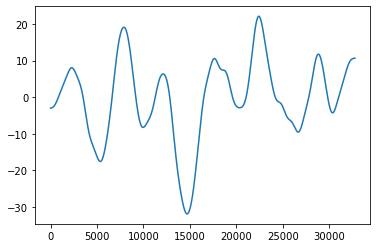

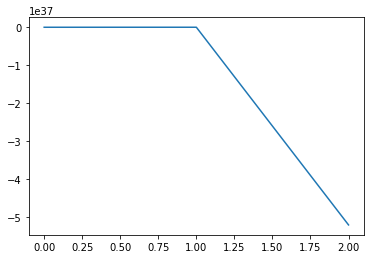

Butterworth filter applied to data


In [89]:
# 2.1: Apply butter_sos to data
print("Applying Butterworth to data")
print(witness_data.shape)
plt.plot(witness_data[0][:,0])
plt.show()
for idx in range(len(witness_data)):
    for channel in range(channels):
        witness_data[idx][:, channel] = signal.sosfilt(butter_sos, witness_data[idx][:, channel])
plt.plot(witness_data[0][:,0])
plt.show()
print("Butterworth filter applied to data")

Normalization in progress


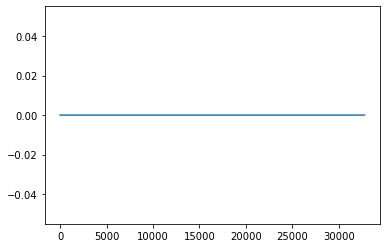

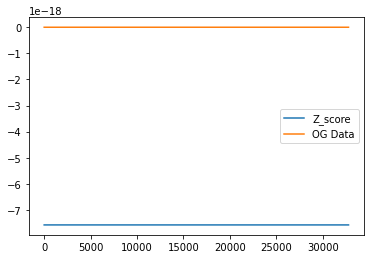

Normalization Complete


In [81]:

# 3: Standard Scalar (Z-score)
print("Normalization in progress")

plt.plot(witness_data[0][:,0])
plt.show()

scaler = StandardScaler()
strain_data = np.reshape(strain_data, (-1,1))
scaler.fit(strain_data)
strain_data = scaler.transform(strain_data)


test_1 = scaler.transform(np.reshape(witness_data[1][:,0], (-1,1)))



plt.plot(test_1, label = "Z_score")
plt.plot(witness_data[0][:,0], label = "OG Data")
plt.legend()
plt.show()
# print(witness_data.shape)

# for idx in range(len(witness_data)):
#     for channel in range(channels):
#         reshaped_witness_data = np.reshape(witness_data[idx][:, channel], (-1,1))
#         reshaped_witness_data = scaler.transform(reshaped_witness_data)
# print(witness_data.shape)


print("Normalization Complete")

In [21]:
# 4: Windowing
window_length = 8
DFT_length = 2
sample_rate = 4096
window_size = window_length * sample_rate
DFT_size = DFT_length * sample_rate
overlap_percent = 0.96875



In [24]:
# 5: Welches Method
print("Applying Welch's Method")
window_type = 'hann'
nperseg_train = window_size
noverlap_train = window_size*(1-overlap_percent)
nfft = DFT_size

for batch in range(len(witness_data)):
    for channel in range(channels):
        witness_data[idx][:, channel] = signal.welch(witness_data[idx][:, channel], sample_rate, window = 'hann')
        
print("Welch's Method Complete")

Applying Welch's Method
(22020096, 1)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [21]:
print(X_batch.shape)
print(X_batch.shape[0])
print(X_batch.shape[1])
print(X_batch.shape[2])

(32, 32768, 21)
32
32768
21


In [43]:
#Implement neural network.

#TOY MODEL COPY-PASTED FROM HW3
#MODEL FOR PART B, MODIFIED TO REPLICATE
#FIGURE 7 IN THE SOURCE WORK
from tensorflow import keras

#Check input shape, given dataset is sampled at 4096Hz
model = keras.models.Sequential(name="attempt_1")
#Convolution Layers
model.add(layers.Conv1D(filters=21, kernel_size=5, strides=1, padding="same", activation="tanh",\
                        input_shape=(X_batch.shape[1], X_batch.shape[0])))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=8, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=16, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=32, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=64, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())

#Deconvolution Layers
model.add(layers.Conv1DTranspose(filters=32, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=8, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1DTranspose(filters=21, kernel_size=5, strides=2, padding="same", activation="tanh"))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(filters=1, kernel_size=5, padding="same", name = "output"))

model.build((None, X_batch.shape[1], X_batch.shape[0]))
model.summary()

Model: "attempt_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_131 (Conv1D)         (None, 32768, 21)         3381      
                                                                 
 batch_normalization_230 (Ba  (None, 32768, 21)        84        
 tchNormalization)                                               
                                                                 
 conv1d_132 (Conv1D)         (None, 16384, 8)          848       
                                                                 
 batch_normalization_231 (Ba  (None, 16384, 8)         32        
 tchNormalization)                                               
                                                                 
 conv1d_133 (Conv1D)         (None, 8192, 16)          656       
                                                                 
 batch_normalization_232 (Ba  (None, 8192, 16)         64